In [5]:
import numpy as np
import cvxpy as cp
import torch

In [6]:
import tqdm

In [7]:
from scipy.linalg import eigh
from scipy.stats import chi2, beta

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.decomposition import KernelPCA

In [9]:
from matplotlib import pyplot as plt

In [10]:
import warnings

### Synthetic Data from Kallus 2018

In [11]:
nu = 0.0  # smaller Gamma than 0.1
beta0 = 2.5
beta0_t = -2
beta_x = np.asarray([0, 0.5, -0.5, 0, 0])
beta_x_t = np.asarray([-1.5, 1, -1.5, 1.0, 0.5])
beta_xi = 1
beta_xi_t = -2
beta_e_x = np.asarray([0, 0.75, -0.5, 0, -1])
mu_x = np.asarray([-1, 0.5, -1, 0, -1])


def generate_data(n):
    xi = (np.random.rand(n) > 0.5).astype(int)
    X = mu_x[None, :] + np.random.randn(n * 5).reshape(n, 5)
    eps = [np.random.randn(n) for t in (0, 1)]
    Y = np.array(
        [X @ (beta_x + beta_x_t * t) + (beta_xi + beta_xi_t * t) * xi + (beta0 + beta0_t * t) + eps[t] for t in (0, 1)]
    )
    U = (Y[0, :] > Y[1, :]).astype(int)
    z = X @ beta_e_x
    e_x = np.exp(z) / (1 + np.exp(z))
    mu_xu = (6 * e_x) / (4 + 5 * U + e_x * (2 - 5 * U))
    mu_xu = np.clip(mu_xu, 1e-6, 1 - 1e-6)
    ber = np.random.rand(n) < nu
    unif = np.random.rand(n)
    a, b = 4 * mu_xu + 1, 4 * (1 - mu_xu) + 1
    T = (1 - ber) * beta.rvs(a, b) + ber * unif
    e_xu = (1 - nu) * beta.pdf(T, a, b) + nu
    Y = (1 - T) * Y[0, :] + T * Y[1, :]
    return Y, T, X, U, e_x, e_xu


def evaluate_policy(policy, n=1000, requires_grad=False):
    xi = (np.random.rand(n) > 0.5).astype(int)
    X = mu_x[None, :] + np.random.randn(n * 5).reshape(n, 5)
    eps = [np.random.randn(n) for t in (0, 1)]
    Y = np.array(
        [X @ (beta_x + beta_x_t * t) + (beta_xi + beta_xi_t * t) * xi + (beta0 + beta0_t * t) + eps[t] for t in (0, 1)]
    )
    T = policy(X).rsample() if requires_grad else policy(X).sample()
    Y = torch.as_tensor(Y) if isinstance(T, torch.Tensor) else Y
    Y = (1 - T) * Y[0, :] + T * Y[1, :]
    return Y.mean()

In [12]:
n = 1000
np.random.seed(0)
Y, T, X, U, e_x, e_xu = generate_data(n)

In [13]:
e_xu.min(), e_xu.max()

(0.011542609734976688, 4.622632437151573)

In [14]:
max(1 / e_xu)

86.6355202991726

In [15]:
np.mean(T / e_xu)

0.47806494622818213

In [16]:
def toy_policy(X):
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    mu_t = torch.exp(z) / (1 + torch.exp(z))
    a, b = 3 * mu_t + 1, 3 * (1 - mu_t) + 1
    return torch.distributions.beta.Beta(a, b)


# def zero_policy(X):
#    return np.zeros(X.shape[0], dtype=int)

In [17]:
evaluate_policy(toy_policy)

tensor(3.9055, dtype=torch.float64)

### Estimate Propensity Score (Conditional Density Estimation)

#### Discrete Case

In [18]:
class betaUnifMixture(torch.nn.Module):
    def __init__(self, a=torch.ones(1), b=torch.ones(1), logit_nu=torch.zeros(1)):
        super().__init__()
        self.beta = torch.distributions.beta.Beta(a, b)
        self.logit_nu = logit_nu

    def log_prob(self, X):
        unif_log_pdf = 0.0
        beta_log_pdf = self.beta.log_prob(X)
        mix_log_pdf = torch.logsumexp(
            torch.stack(
                [
                    torch.nn.functional.logsigmoid(self.logit_nu) * torch.ones(X.shape[0]) + unif_log_pdf,
                    torch.nn.functional.logsigmoid(-self.logit_nu) + beta_log_pdf,
                ]
            ),
            axis=0,
        )
        return mix_log_pdf

    def prob(self, X):
        unif_pdf = 1.0
        beta_pdf = torch.exp(self.beta.log_prob(X))
        mix_pdf = torch.sigmoid(self.logit_nu) * unif_pdf + torch.sigmoid(-self.logit_nu) * beta_pdf
        return mix_pdf


class betaUnifMixtureRegression(torch.nn.Module):
    def __init__(self, coef_a_init, coef_b_init, logit_nu_init=0.0, link=torch.sigmoid):
        super().__init__()
        self.coef_a = torch.nn.Parameter(torch.as_tensor(coef_a_init))
        self.coef_b = torch.nn.Parameter(torch.as_tensor(coef_b_init))
        self.logit_nu = torch.nn.Parameter(torch.as_tensor(logit_nu_init))
        self.link = link

    def train(self, X, T, n_iter=100, lr=1e-2):
        X, T = map(torch.as_tensor, (X, T))
        optimizer = torch.optim.RMSprop(params=self.parameters())
        pbar = tqdm.tqdm(range(n_iter))
        for i in pbar:
            loss = -self.predict_log_prob(X, T).mean()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            pbar.set_description(f"Step: {i}\tLoss:\t{loss.item()}")

    def predict_log_prob(self, X, T):
        X, T = map(torch.as_tensor, (X, T))
        X = torch.cat([torch.ones(X.shape[0], 1), X], axis=1)
        a = self.link(X @ self.coef_a)
        b = self.link(X @ self.coef_b)
        dist = betaUnifMixture(a, b, self.logit_nu)
        return dist.log_prob(T)

    def predict_prob(self, X, T):
        X, T = map(torch.as_tensor, (X, T))
        X = torch.cat([torch.ones(X.shape[0], 1), X], axis=1)
        a = self.link(X @ self.coef_a)
        b = self.link(X @ self.coef_b)
        dist = betaUnifMixture(a, b, self.logit_nu)
        return dist.prob(T)

In [19]:
coef_a = np.ones(6)
coef_b = np.ones(6)
model = betaUnifMixtureRegression(coef_a, coef_b)

In [20]:
model.train(X, T)

Step: 99	Loss:	-0.1022260196748627: 100%|██████████| 100/100 [00:00<00:00, 368.26it/s]


In [21]:
model.logit_nu

Parameter containing:
tensor(-0.2069, requires_grad=True)

In [22]:
entropy = model.predict_log_prob(X, T).mean()
entropy

tensor(0.1026, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [23]:
# Logistic regression is already quite good
from statsmodels.othermod.betareg import BetaModel

model = BetaModel(endog=T, exog=X)
result = model.fit()
params = result.params
mu_t = model.predict(params, X)
log_e_x = model.loglikeobs(params)

np.mean(np.abs(mu_t - T)), np.max(np.abs(log_e_x - np.log(e_xu)))

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")


(0.1384975511544807, 1.510732286885275)

In [24]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              BetaModel Results                               
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                 473.10
Model:                      BetaModel   AIC:                            -936.2
Method:            Maximum Likelihood   BIC:                            -911.7
Date:                Sat, 01 Oct 2022                                         
Time:                        22:54:45                                         
No. Observations:                1000                                         
Df Residuals:                     994                                         
Df Model:                           5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0653      0.023     -2.790      0.005      -0.111      -0.019
x2             0.3513      0.027     13.063      0.000       0.299       0.404
x3            -0.2842      0.023    -12.611      0.000      -0.328      -0.240
x4             0.0331      0.027      1.226      0.220      -0.020       0.086
x5            -0.3700      0.023    -16.192      0.000      -0.415      -0.325
precision      1.7292      0.043     40.179      0.000       1.645       1.814
==============================================================================
"""

In [25]:
result.aic

-936.2029544677196

In [26]:
Z = KernelPCA(n_components=2, kernel="rbf", gamma=0.01).fit_transform(X)
model = BetaModel(endog=T, exog=np.concatenate([Z, X], axis=1))
params = model.fit().params
e_xx = np.exp(model.loglikeobs(params))

np.max(np.abs(np.log(e_xx) - np.log(e_xu)))

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")


1.455959894133339

In [27]:
# want to run this!
Gamma = np.max(np.abs(np.log(e_xu) - np.log(e_xx)))
Gamma

1.455959894133339

In [28]:
np.mean(1 / e_x * T)  # it should be 0.5

0.8862527758727261

In [29]:
np.mean(1 / e_xx * T)  # it should be 0.5

0.4785194038596378

In [30]:
np.mean(1 / e_xu * T)  # it should be 0.5

0.4780649462281821

In [31]:
p_t = e_xx

### Ground Truth

In [32]:
evaluate_policy(toy_policy, n=1000000)

tensor(3.8199, dtype=torch.float64)

### IPW estimator

In [33]:
def IPW(r, p_t, return_w=False):
    if isinstance(r, torch.Tensor):
        est = torch.mean(r / torch.as_tensor(p_t))
    else:
        est = np.mean(r / p_t)
    return (est, w) if return_w else est

In [34]:
policy_prob = torch.exp(toy_policy(X).log_prob(torch.as_tensor(T)))
est_ipw = IPW(torch.as_tensor(Y) * policy_prob, p_t)

In [35]:
est_ipw

tensor(3.9503, dtype=torch.float64)

### Implement Confounding Robust Quantile Balancing Estimator    

In [39]:
def get_a_b(p_t, gamma):
    a = 1 / p_t / gamma
    b = 1 / p_t * gamma
    return a, b

In [40]:
a, b = get_a_b(e_xx, Gamma)

In [46]:
from sklearn.linear_model import QuantileRegressor

In [56]:
def confoundingRobustQuantileBalancing(r, T, X, gamma, p_t, return_w=False):
    r_np = r.data.numpy() if isinstance(r, torch.Tensor) else r
    a, b = get_a_b(p_t, gamma)
    with warnings.catch_warnings():  # to avoid user warning about multiplication operator with `*` and `@`
        warnings.simplefilter("ignore")
        w = quantileLP(r_np, T, X, a, b, p_t, r.shape[0], gamma)
    if isinstance(r, torch.Tensor):
        est = torch.mean(torch.as_tensor(w) * r)
    else:
        est = np.mean(w * r_np)
    return (est, w) if return_w else est


def quantileLP(r, T, X, a, b, e, n, gamma):
    m = r.shape[0]
    TX = np.concatenate([T[:, None], X], axis=1)
    TX /= TX.std(axis=0)[None, :]
    q = (
        QuantileRegressor(quantile=(1.0 - gamma ** (-1)) / (gamma - gamma ** (-1)), alpha=0.0).fit(TX, r).predict(TX)
    )  # any regressor will do,
    w = cp.Variable(m)
    phi = cp.Variable()
    constraints = [
        np.zeros(m) <= w,
        0 <= phi,
        a * phi <= w,
        w <= b * phi,
        cp.sum(w) == n,
        cp.sum(w * q) == np.sum(q / e),
    ]
    objective = cp.Minimize(cp.sum(r * w))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return w.value

In [57]:
Gamma = 1.5
est, w = confoundingRobustQuantileBalancing(torch.as_tensor(Y) * policy_prob, T, X, Gamma, p_t, return_w=True)

In [58]:
est

tensor(3.4086, dtype=torch.float64)

### Implement Confounding Robust Kernel Estimator

In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF

In [35]:
def confoundingRobustKernel(
    r,
    T,
    X,
    a,
    b,
    p_t,
    lambd=None,
    kernel=None,
    *,
    alpha=0.01,
    return_w=False,
    rank_constraints=100,
    hard_constraint=False,
):
    r_np = r.data.numpy() if isinstance(r, torch.Tensor) else r
    rank_constraints = min(rank_constraints, n)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        w = KernelLP(r_np, T, X, a, b, p_t, lambd, kernel, alpha, rank_constraints, hard_constraint)
    if isinstance(r, torch.Tensor):
        est = torch.mean(torch.as_tensor(w) * r)
    else:
        est = np.mean(w * r_np)
    return (est, w) if return_w else est


def KernelLP(r, T, X, a, b, p_t, lambd, kernel, alpha, rank_constraints, hard_constraint):
    n = r.shape[0]
    assert rank_constraints <= n

    w = cp.Variable(n)
    constraints = [
        np.zeros(n) <= w,
        a <= w,
        w <= b,
    ]

    if rank_constraints > 0:
        M, u, Cov_z, rank_constraints = getGPQC(r, T, X, a, b, p_t, rank_constraints, lambd, kernel)
        chi2_bound = chi2(df=rank_constraints).ppf(1 - alpha)
        z = cp.Variable(rank_constraints)
        constraints += [
            # cp.sum(T * w) == 0.5 * n,  # this somehow decreases the bound, probably through the choice of kernel
            z == M @ w - u,
            np.zeros(rank_constraints) == z if hard_constraint else cp.sum(z**2 / Cov_z) <= chi2_bound,
        ]
    objective = cp.Minimize(cp.sum(r * w))
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return w.value


def getGPQC(r, T, X, a, b, p_t, rank_constraints, lambd=None, kernel=None):
    TX = np.concatenate([T[:, None], X], axis=1)
    TX /= TX.std(axis=0)[None, :]

    if not (lambd and kernel):
        _, w = confoundingRobustKernel(
            r[:1000],
            T[:1000],
            X[:1000],
            a[:1000],
            b[:1000],
            p_t[:1000],
            lambd=0.2 * np.mean((b - a) / p_t),
            kernel=RBF(),
            return_w=True,
            rank_constraints=0,
        )
        e = w * p_t - 1
        kernel_ = WhiteKernel() + ConstantKernel() * RBF()
        model = GaussianProcessRegressor(kernel=kernel_).fit(TX[:1000], e[:1000])
        lambd = model.kernel_.k1.noise_level
        kernel = model.kernel_.k2

    K = kernel(TX, TX)
    S, V = eigh(K, subset_by_index=[n - rank_constraints, n - 1])
    S, V = cutoff_neg_eigvals(S, V)

    M = np.diag(S / (S + lambd)) @ V.T @ np.diag(p_t)
    u = np.diag(S / (S + lambd)) @ V.T @ np.ones(n)
    Cov_z = S - S**2 / (S + lambd)

    return M, u, Cov_z, u.shape[0]


def cutoff_neg_eigvals(S, V):
    V = V[:, S > 1e-6]
    S = S[S > 1e-6]
    return S, V

In [36]:
est, w = confoundingRobustKernel(torch.as_tensor(Y) * policy_prob, T, X, a, b, p_t, return_w=True)

In [37]:
est

tensor(3.4937, dtype=torch.float64)

In [38]:
est, w = confoundingRobustKernel(
    torch.as_tensor(Y) * policy_prob, T, X, a, b, p_t, return_w=True, hard_constraint=True
)

In [39]:
est

tensor(3.6681, dtype=torch.float64)

### Compare Policy Learning Performance

In [40]:
def base_policy(X):
    mu_t = 0.5 * torch.ones(X.shape[0])
    a, b = 10 * mu_t + 1, 10 * (1 - mu_t) + 1
    return torch.distributions.beta.Beta(a, b)


def LR_policy(X, beta):
    X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
    mu_t = torch.sigmoid(torch.tensor(X) @ beta)
    a, b = 10 * mu_t + 1, 10 * (1 - mu_t) + 1
    return torch.distributions.beta.Beta(a, b)

In [41]:
class nnPolicy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(5, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid(),
        )
        self.nn[-2].weight.data[:] = 0.0
        self.nn[-2].bias.data[:] = 0.0

    def forward(self, X):
        X = torch.as_tensor(X, dtype=torch.float32)
        mu_t = torch.sigmoid(self.nn(X)[:, 0])
        a, b = 10 * mu_t + 1, 10 * (1 - mu_t) + 1
        return torch.distributions.beta.Beta(a, b)

In [42]:
evaluate_policy(base_policy, n=100000)

tensor(3.7412, dtype=torch.float64)

In [43]:
nn_policy = nnPolicy()
evaluate_policy(nn_policy, n=100000)

tensor(3.7508, dtype=torch.float64)

#### Select Kernel

In [44]:
r = torch.as_tensor(Y) * policy_prob
TX = np.concatenate([T[:, None], X], axis=1)
TX /= TX.std(axis=0)[None, :]
_, w = confoundingRobustKernel(r, T, X, a, b, p_t, lambd=0.2 * np.mean((b - a) / p_t), kernel=RBF(), return_w=True)
e = w * p_t - 1
kernel_ = WhiteKernel() + ConstantKernel() * RBF()
model = GaussianProcessRegressor(kernel=kernel_).fit(TX[:1000], e[:1000])
lambd = model.kernel_.k1.noise_level
kernel = model.kernel_.k2

#### Best Policy

In [45]:
train_steps = 101
beta_best = torch.zeros(6, requires_grad=True, dtype=float)
best_policy = lambda X: LR_policy(X, beta_best)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_best])
# best_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=1e-2, params=best_policy.parameters(), weight_decay=0.00)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    value = evaluate_policy(best_policy, n=100000, requires_grad=True)
    (-value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

Value: 4.582946057174564: 100%|█████████████████████| 101/101 [00:16<00:00,  6.27it/s]


#### Just Run IPW optimization

In [46]:
train_steps = 101
beta_ipw = torch.zeros(6, requires_grad=True, dtype=float)
ipw_policy = lambda X: LR_policy(X, beta_ipw)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_ipw])
# ipw_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=1e-2, params=ipw_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    ipw_prob = torch.exp(ipw_policy(X).log_prob(torch.as_tensor(T)))
    r = ipw_prob * torch.as_tensor(Y)
    value = IPW(r, p_t)
    (-value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

Value: 4.805373767995637: 100%|████████████████████| 101/101 [00:00<00:00, 462.56it/s]


In [47]:
evaluate_policy(ipw_policy, n=100000)

tensor(4.3059, dtype=torch.float64)

In [48]:
est = confoundingRobustKernel(r, T, X, a, b, p_t)
est

tensor(3.7729, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [49]:
est = confoundingRobustKernel(r, T, X, a, b, p_t, hard_constraint=True)
est

tensor(3.9555, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [50]:
r = torch.as_tensor(Y) * ipw_prob
rank = [j**2 for j in range(1, 32)]
y = []
for i in tqdm.tqdm(rank):
    y.append(confoundingRobustKernel(r, T, X, a, b, p_t, rank_constraints=i))

100%|█████████████████████████████████████████████████| 31/31 [07:10<00:00, 13.89s/it]


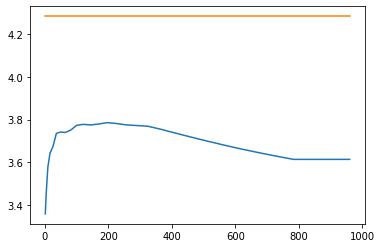

In [51]:
plt.plot(rank, [value.detach().numpy() for value in y])
plt.plot(rank, [evaluate_policy(ipw_policy, n=100000).detach().numpy()] * len(rank))

In [52]:
r = torch.as_tensor(Y) * ipw_prob
rank = [j**2 for j in range(1, 32)]
y_hard = []
for i in tqdm.tqdm(rank):
    y_hard.append(confoundingRobustKernel(r, T, X, a, b, p_t, rank_constraints=i, hard_constraint=True))

100%|█████████████████████████████████████████████████| 31/31 [07:49<00:00, 15.16s/it]


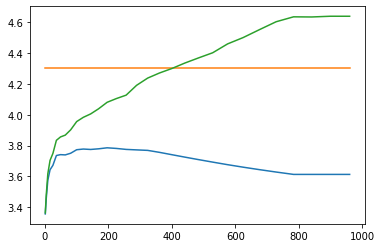

In [53]:
plt.plot(rank, [value.detach().numpy() for value in y])
plt.plot(rank, [evaluate_policy(ipw_policy, n=100000).detach().numpy()] * len(rank))
plt.plot(rank, [value.detach().numpy() for value in y_hard])

In [54]:
Y.std() / 1000**0.5

0.07921102173711257

#### Compare Policy Improvement

In [55]:
evaluate_policy(base_policy, n=100000)

tensor(3.7452, dtype=torch.float64)

In [56]:
# Kernel policy improvement
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X: LR_policy(X, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
# kernel_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=kernel_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    base_prob = torch.exp(base_policy(X).log_prob(torch.as_tensor(T)))
    kernel_prob = torch.exp(kernel_policy(X).log_prob(torch.as_tensor(T)))
    r = torch.tensor(Y) * (kernel_prob - base_prob)
    kernel_improvement, w = confoundingRobustKernel(r, T, X, a, b, p_t, lambd, kernel, return_w=True)
    (-kernel_improvement).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Improvement: {kernel_improvement}")

Improvement: -1.102541939967283: 100%|██████████████| 101/101 [01:09<00:00,  1.46it/s]


In [57]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.2007, dtype=torch.float64)

In [58]:
# Kernel policy improvement
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X: LR_policy(X, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
# kernel_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=kernel_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    base_prob = torch.exp(base_policy(X).log_prob(torch.as_tensor(T)))
    kernel_prob = torch.exp(kernel_policy(X).log_prob(torch.as_tensor(T)))
    r = torch.tensor(Y) * (kernel_prob - base_prob)
    kernel_improvement, w = confoundingRobustKernel(
        r, T, X, a, b, p_t, lambd, kernel, return_w=True, hard_constraint=True
    )
    (-kernel_improvement).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Improvement: {kernel_improvement}")

Improvement: -0.06409251428928084: 100%|████████████| 101/101 [01:06<00:00,  1.53it/s]


In [59]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.1443, dtype=torch.float64)

### Just run min-max optimzation

In [60]:
# Kernel policy min-max value
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X: LR_policy(X, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
# kernel_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=kernel_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    kernel_prob = torch.exp(kernel_policy(X).log_prob(torch.as_tensor(T)))
    r = torch.tensor(Y) * kernel_prob
    kernel_value, w = confoundingRobustKernel(r, T, X, a, b, p_t, lambd, kernel, return_w=True, rank_constraints=0)
    (-kernel_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {kernel_value}")

Value: 3.2600708536233047: 100%|████████████████████| 101/101 [00:01<00:00, 64.35it/s]


In [61]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.2720, dtype=torch.float64)

In [62]:
# Kernel policy min-max value
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X: LR_policy(X, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
# kernel_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=kernel_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    kernel_prob = torch.exp(kernel_policy(X).log_prob(torch.as_tensor(T)))
    r = torch.tensor(Y) * kernel_prob
    kernel_value, w = confoundingRobustKernel(r, T, X, a, b, p_t, lambd, kernel, return_w=True)
    (-kernel_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {kernel_value}")

Value: 3.52519221890188: 100%|██████████████████████| 101/101 [01:08<00:00,  1.48it/s]


In [63]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.2410, dtype=torch.float64)

In [64]:
# Kernel policy min-max value
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X: LR_policy(X, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
# kernel_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=kernel_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    kernel_prob = torch.exp(kernel_policy(X).log_prob(torch.as_tensor(T)))
    r = torch.tensor(Y) * kernel_prob
    kernel_value, w = confoundingRobustKernel(r, T, X, a, b, p_t, lambd, kernel, return_w=True, hard_constraint=True)
    (-kernel_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {kernel_value}")

Value: 3.9800341978504337: 100%|████████████████████| 101/101 [01:01<00:00,  1.65it/s]


In [65]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.1129, dtype=torch.float64)

### Conclusions
- The difference in performance is sample-dependent
  - If the sample is well confounded, then kernel + hajek tends to be better than hajek
- IPW estimator is good enough in most cases, so we might not actually need confounding-robust methods
- Still, kernel + hajek method offers better lower-bound of the policy value, so it must have some use cases.hard_constraint=

### Make a Table for Slide

In [146]:
pi1 = lambda x: 0.5
pi2 = toy_policy
pi3 = best_policy
pi4 = hajek_policy
pi5 = kernel_policy
pi6 = ipw_policy

In [147]:
table = {}
for i, pi in tqdm.tqdm(enumerate([pi1, pi2, pi3, pi4, pi5, pi6])):
    table[f"$\\pi_{i+1}$"] = row = {}
    row["$V_\\text{inf}$"] = float(evaluate_policy(pi, n=100000))
    prob = pi(X) * torch.tensor(T) + (1 - pi(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * prob
    row["$\\hat V_\\text{inf}^\\Hajek$"] = float(confoundingRobustHajek(r, T, a, b))
    row["$\\hat V_\\text{inf}^\\kernel$"] = float(confoundingRobustKernel(r, T, X, a, b, p_t))
    row["$\\hat V_\\text{inf}^\\text{IPW}$"] = float(IPW(r, p_t))

6it [00:36,  6.15s/it]


In [151]:
table_copy = table.copy()
table.pop("$\\pi_6$")

{'$V_\\text{inf}$': 4.671451375254245,
 '$\\hat V_\\text{inf}^\\text{IPW}$': 4.856568494405989,
 '$\\hat V_\\text{inf}^\\Hajek$': 4.427088859626212,
 '$\\hat V_\\text{inf}^\\kernel$': 4.6642975558017366}

In [152]:
print("\\begin{tabular}{ | m{4em} || " + "m{3em} " * len(table) + "| }")
print("\\hline")
header = "{}\t" + "&{}\t" * len(table) + "\\\\"
print(header.format("", *table.keys()))
print("\\hline")

row_names = table["$\\pi_1$"].keys()
for row in row_names:
    s = "{}\t" + "&{:1.3f}\t" * len(table) + "\\\\"
    print(s.format(row, *[col[row] for col in table.values()]))
    print("\\hline")
print("\\end{tabular}")

\begin{tabular}{ | m{4em} || m{3em} m{3em} m{3em} m{3em} m{3em} | }
\hline
	&$\pi_1$	&$\pi_2$	&$\pi_3$	&$\pi_4$	&$\pi_5$	\\
\hline
$V_\text{inf}$	&3.757	&3.898	&4.736	&4.576	&4.670	\\
\hline
$\hat V_\text{inf}^\text{IPW}$	&3.583	&3.920	&4.738	&4.722	&4.827	\\
\hline
$\hat V_\text{inf}^\Hajek$	&3.546	&3.716	&4.302	&4.447	&4.417	\\
\hline
$\hat V_\text{inf}^\kernel$	&3.566	&3.855	&4.548	&4.560	&4.652	\\
\hline
\end{tabular}


### Estimate Propensity Score (Conditional Density Estimation)
- This requires consistent nominal propensity score (p_obs(t|x))
- For discrete t, just run kernel logistic regressionregret_kernel

#### Discrete Case

In [356]:
from sklearn.linear_model import LogisticRegressionCV

# from sklearn.metrics import roc_auc_score, make_scorer
# roc_auc_score = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

model = LogisticRegressionCV().fit(X, T)
e_xx = model.predict_proba(X)[:, 1]

np.mean(np.abs(e_xx - e_x))

0.03245225608333301

In [9]:
import optuna
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


def objective(trial):
    gamma = trial.suggest_float("gamma", 1e-2, 1e2, log=True)
    lambd = trial.suggest_float("lambd", 1e-3, 1e3, log=True)
    model = Pipeline(
        [
            ("kpca", KernelPCA(n_components=100, kernel="rbf", gamma=gamma)),
            ("LogReg", LogisticRegression(C=1 / lambd)),
        ]
    )
    cv_scores = cross_val_score(model, X, y=T, cv=4)
    return cv_scores.mean()

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(func=objective, n_trials=100)

In [332]:
study.best_params

{'gamma': 0.010034979398825772, 'lambd': 0.21459944940837156}

In [10]:
Z = KernelPCA(n_components=200, kernel="rbf", gamma=0.01).fit_transform(X)
model = LogisticRegression(C=5).fit(Z, T)
e_xx = model.predict_proba(Z)[:, 1]

np.mean(np.abs(e_xx - e_x))

0.023502960435053497

In [11]:
np.mean(1 / e_x * T), np.mean(1 / (1 - e_x) * (1 - T)),  # both should be 1

(0.9926845079200554, 0.9795193002344411)

In [12]:
np.mean(1 / e_xx * T), np.mean(1 / (1 - e_xx) * (1 - T)),  # both should be 1

(0.9978398603769248, 0.9503035986662446)

#### Continuous Case (Maybe on the next notebook)

In [598]:
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional

In [614]:
EPS = 1e-6


def benchmark_bandwidth(bw, T, X, cv=5):
    n = T.shape[0]
    indep_type = "c" * X.shape[1]
    dep_type = "u"
    split = np.arange(n) % 5
    cross_entropy = 0
    for i in range(cv):
        train = split != i
        test = split == i
        model = KDEMultivariateConditional(
            T[train, None], X[train, :], dep_type="c", indep_type="c" * X.shape[1], bw=bw
        )
        cross_entropy += np.mean(model.pdf(T[test, None], X[test, :]) + EPS) / cv
    return cross_entropy

In [615]:
best_scale = 0
best_score = -float("inf")
for scale in [0.1, 0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3, 5]:
    bw = scale * np.concatenate([[Y.std()], X.std(axis=0)]) / Y.shape[0] ** (1 / 7)
    score = benchmark_bandwidth(bw, Y, X)
    if score > best_score:
        best_scale = scale
        best_score = score

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_density.py:527: RuntimeWarning: invalid value encountered in double_scalars
  pdf_est.append(f_yx / f_x)


In [616]:
best_scale, best_score

(0.3, 0.19784318708431387)

In [637]:
bw0 = best_scale * np.concatenate([[Y.std()], X.std(axis=0)]) / Y.shape[0] ** (1 / 7)
model = KDEMultivariateConditional(Y[:, None], X, dep_type="c", indep_type="c" * X.shape[1], bw=bw0)

In [638]:
e_xx = model.pdf(Y[:, None], X)
e_xx

array([1.62958717, 1.62951695, 1.62941804, ..., 1.62956773, 1.62958717,
       1.62958716])

(array([3.000e+00, 5.000e+00, 7.000e+00, 9.000e+00, 2.100e+01, 2.500e+01,
        2.900e+01, 4.700e+01, 1.230e+02, 7.731e+03]),
 array([1.15235734, 1.20008033, 1.24780331, 1.29552629, 1.34324927,
        1.39097226, 1.43869524, 1.48641822, 1.5341412 , 1.58186419,
        1.62958717]),
 <BarContainer object of 10 artists>)

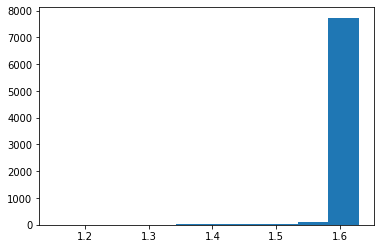

In [639]:
plt.hist(e_xx)

In [640]:
model.bw

array([0.24481187, 0.08247946, 0.08201479, 0.08216818, 0.08203077,
       0.08354723])

In [636]:
[np.mean(1.0 / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1

[0.0036205488784271846,
 0.005530541824885594,
 0.008353342645354245,
 0.0092354679017507,
 0.008828923218367986,
 0.006834553073471655,
 0.0047634763845408505]

In [650]:
# Shouldn't we use loo estimate for propensity? (For reducing the sampling bias)

In [651]:
model_loocv = KDEMultivariateConditional(Y[:500, None], X[:500], dep_type="c", indep_type="c" * X.shape[1], bw="cv_ml")
model_loocv = KDEMultivariateConditional(Y[:, None], X, dep_type="c", indep_type="c" * X.shape[1], bw=model_loocv.bw)
model_loocv.pdf(T[:, None], X)

array([0.00156597, 0.11336096, 0.18019459, ..., 0.15350272, 0.27772491,
       0.00683612])

In [652]:
model_loocv.bw

array([1.16864112, 0.39784615, 0.47414212, 0.34012805, 0.49598966,
       1.03207938])

In [653]:
e_xx = model_loocv.pdf(Y[:, None], X)
e_xx

array([0.16803556, 0.19643081, 0.13837616, ..., 0.08974823, 0.28981744,
       0.16892645])

In [654]:
[np.mean(1.0 / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1

[0.42097172629623864,
 0.5610275108978744,
 0.7806948645405306,
 0.8323803841286099,
 0.8266400377542329,
 0.6698018012108039,
 0.4903058358518989]

In [660]:
Y, T, X, U, e_x, e_xu = generate_data(2000)

In [661]:
# Maybe better to use gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF
from scipy.stats import norm

kernel = WhiteKernel() + ConstantKernel() * RBF()
model = GaussianProcessRegressor(kernel=kernel).fit(X, Y)
mu, sigma = model.predict(X, return_std=True)
e_xx = norm.pdf(Y, loc=mu, scale=sigma)

(array([ 76.,  55.,  81.,  93., 115., 140., 171., 221., 272., 776.]),
 array([2.06249815e-07, 2.74513965e-02, 5.49025868e-02, 8.23537771e-02,
        1.09804967e-01, 1.37256158e-01, 1.64707348e-01, 1.92158538e-01,
        2.19609729e-01, 2.47060919e-01, 2.74512109e-01]),
 <BarContainer object of 10 artists>)

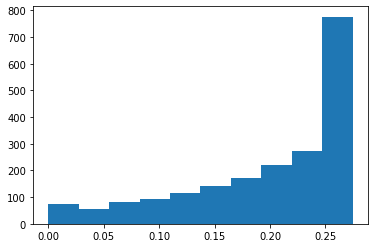

In [662]:
plt.hist(e_xx)

In [663]:
[np.mean(1.0 / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1

[0.32881986213236836,
 0.7800613489446759,
 1.1082520007466337,
 2425.996762904727,
 2.3731976440293625,
 3.270582402658918,
 1.5545976263818995]